### 28/11/2020

### Prueba técnica Hocelot

- Guillermo Andrade Soriano

#### Contenido

Los conjuntos de datos contienen transacciones realizadas con tarjetas de crédito en septiembre de 2013 por titulares de tarjetas europeas.
Este conjunto de datos presenta transacciones que ocurrieron en dos días, donde tenemos 492 fraudes de 284.807 transacciones. El conjunto de datos está muy desequilibrado, la clase positiva (fraudes) representa el 0,172% de todas las transacciones.

Contiene solo variables de entrada numéricas que son el resultado de una transformación PCA. Debido a problemas de confidencialidad, no se puede proporcionar las características originales y más información sobre los datos. Las características V1, V2, … , V28 son las componentes principales obtenidos con PCA, las únicas variables que no se han transformado con PCA son 'Time' y 'Amount'. La variable 'Time' contiene los segundos transcurridos entre cada transacción y la primera transacción en el conjunto de datos. La variable 'Amount' es el importe de la transacción. La variable 'Class' es el Target y toma el valor 1 en caso de fraude y 0 en caso contrario.

#### Objetivo

Identificar transacciones fraudulentas con tarjetas de crédito.

## 0 - Importación de datos y librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, classification_report, auc
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [2]:
plt.style.use('seaborn')
pd.options.display.float_format = "{:.2f}".format

In [3]:
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00,-1.36,-0.07,2.54,1.38,-0.34,0.46,0.24,0.10,0.36,...,-0.02,0.28,-0.11,0.07,0.13,-0.19,0.13,-0.02,149.62,0
1,0.00,1.19,0.27,0.17,0.45,0.06,-0.08,-0.08,0.09,-0.26,...,-0.23,-0.64,0.10,-0.34,0.17,0.13,-0.01,0.01,2.69,0
2,1.00,-1.36,-1.34,1.77,0.38,-0.50,1.80,0.79,0.25,-1.51,...,0.25,0.77,0.91,-0.69,-0.33,-0.14,-0.06,-0.06,378.66,0
3,1.00,-0.97,-0.19,1.79,-0.86,-0.01,1.25,0.24,0.38,-1.39,...,-0.11,0.01,-0.19,-1.18,0.65,-0.22,0.06,0.06,123.50,0
4,2.00,-1.16,0.88,1.55,0.40,-0.41,0.10,0.59,-0.27,0.82,...,-0.01,0.80,-0.14,0.14,-0.21,0.50,0.22,0.22,69.99,0


In [4]:
# Resumen estadístico de las variables
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


## 1 - Exploración de datos e ingeniería de variables

Representamos gráficamente el porcentaje de fraude en nuestro dataset.

Transacciones no fraudulentas: 99.83%
Transacciones fraudulentas: 0.17%


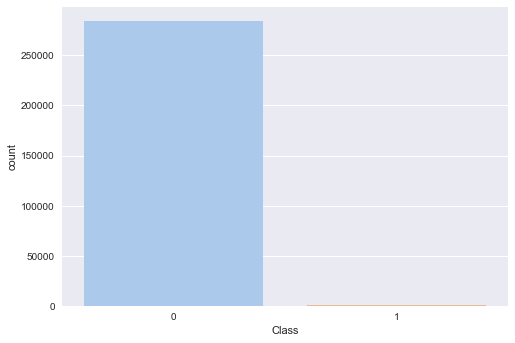

In [5]:
sns.countplot(x='Class', data=df, palette='pastel')
print('Transacciones no fraudulentas: {}%'.format(round(df['Class'].value_counts()[0]/len(df)*100.0,2)))
print('Transacciones fraudulentas: {}%'.format(round(df['Class'].value_counts()[1]/len(df)*100.0,2)))

Representamos las dos variables explicativas que no pertenecen al PCA: Time y Amount

Text(0.5, 1.0, 'Distribución de Time (Class = 1)')

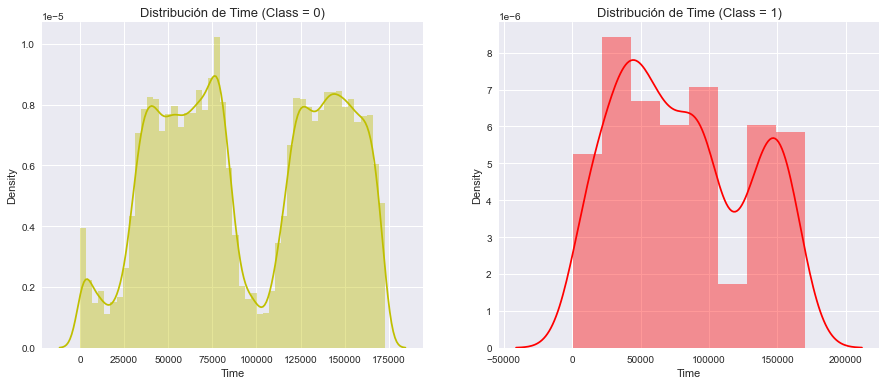

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1 = sns.distplot(df[df['Class']==0]['Time'], ax=ax1, color='y')
ax2 = sns.distplot(df[df['Class']==1]['Time'], ax=ax2, color='r')
ax1.set_title('Distribución de Time (Class = 0)', fontsize=13)
ax2.set_title('Distribución de Time (Class = 1)', fontsize=13)

Text(0.5, 1.0, 'Distribución de Amount (Class = 1)')

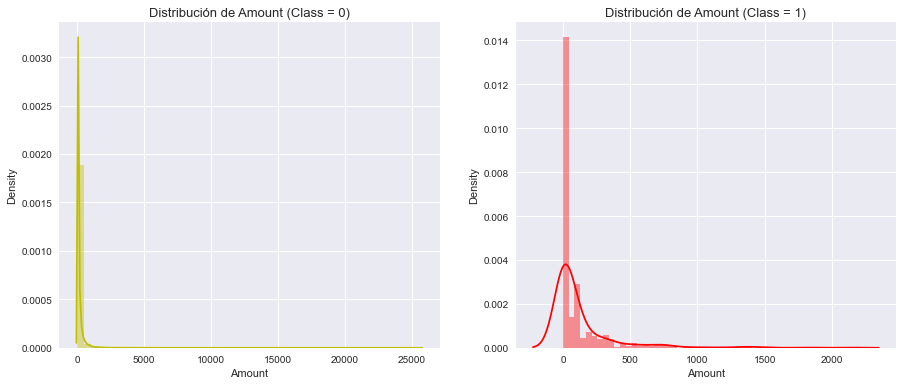

In [7]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1 = sns.distplot(df[df['Class']==0]['Amount'], ax=ax1, color='y')
ax2 = sns.distplot(df[df['Class']==1]['Amount'], ax=ax2, color='r')
ax1.set_title('Distribución de Amount (Class = 0)', fontsize=13)
ax2.set_title('Distribución de Amount (Class = 1)', fontsize=13)

Representamos el logaritmo de la variable Amount, en este caso tomaremos log + 1 ya que esta variable tiene 0s. 

Text(0.5, 1.0, 'Distribución de Amount (Class = 1)')

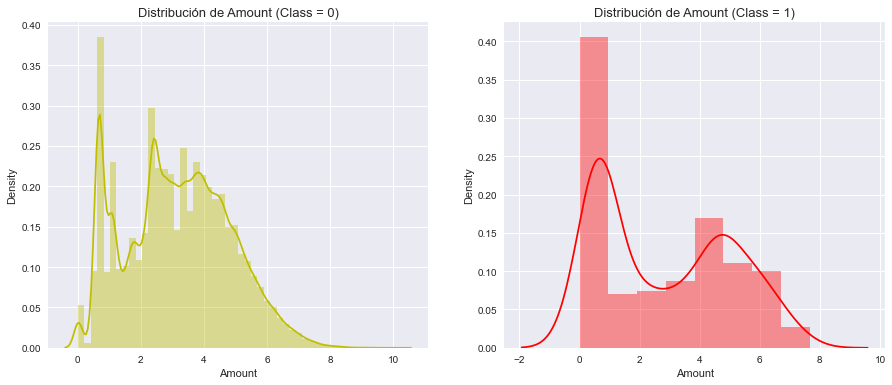

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1 = sns.distplot(np.log(df[df['Class']==0]['Amount']+1), ax=ax1, color='y')
ax2 = sns.distplot(np.log(df[df['Class']==1]['Amount']+1), ax=ax2, color='r')
ax1.set_title('Distribución de Amount (Class = 0)', fontsize=13)
ax2.set_title('Distribución de Amount (Class = 1)', fontsize=13)

Tomaremos esta distribución para entrenar el modelo, ya que así está distribuida de manera más uniforme y no introducirá ruido al modelo.

In [9]:
df['log_Amount'] = np.log(df['Amount'] + 1)

Representamos ahora las correlaciones entre todas las variables del modelo.

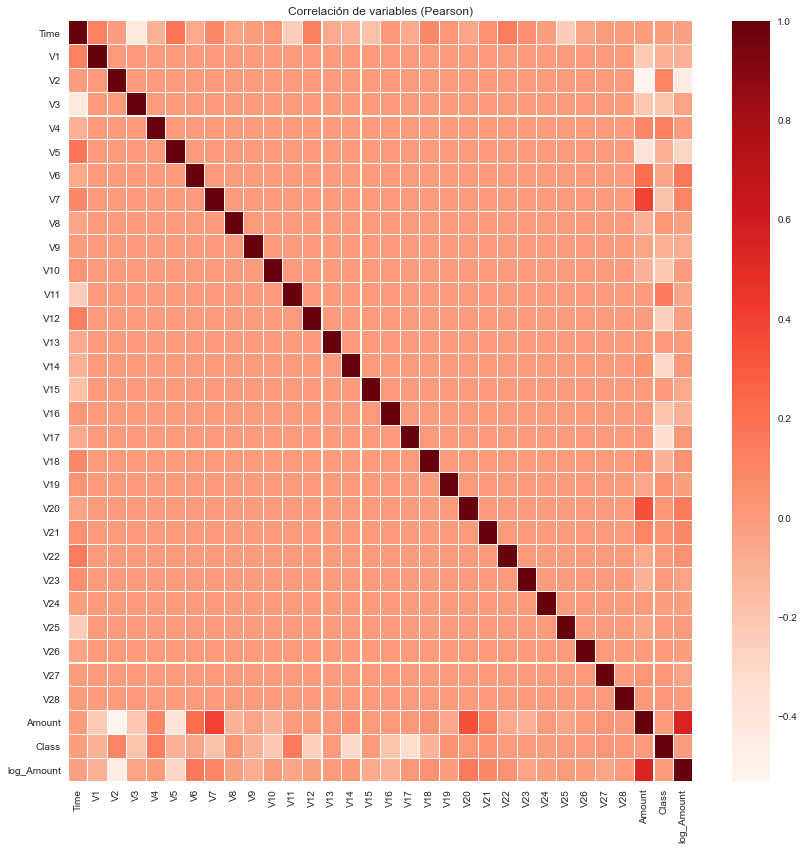

In [10]:
plt.figure(figsize = (14,14))
plt.title('Correlación de variables (Pearson)')
corr = df.corr()
sns.heatmap(corr,xticklabels=corr.columns,yticklabels=corr.columns,linewidths=.1,cmap="Reds")
plt.show()

Las variables del PCA no están correlacionadas entre ellas, como era de esperar ya que el PCA tiene entre sus funciones la eliminación de las correlaciones.

Las dos variables más correlacionadas con nuestro Target (Class) parecen ser V17 y V14, cuya correlación es negativa. Las representamos ahora con diagramas de cajas.

Text(0.5, 1.0, 'Distribución de V14')

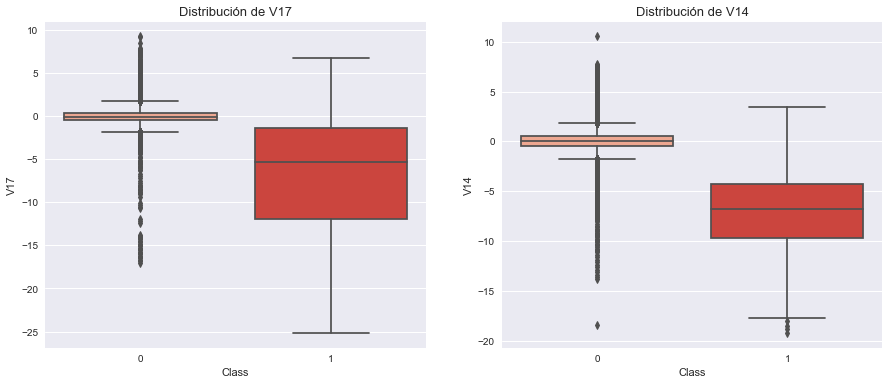

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1 = sns.boxplot(x="Class", y="V17", data=df, ax=ax1, palette="Reds")
ax2 = sns.boxplot(x="Class", y="V14", data=df, ax=ax2, palette="Reds")
ax1.set_title('Distribución de V17', fontsize=13)
ax2.set_title('Distribución de V14', fontsize=13)

En ambas representaciones podemos observar que el rango intercuartílico de la Clase 0 está por encima del rango intercuartílico de la Clase 1. Esto nos adelanta que van a ser variables importantes para nuestros modelos.

Se trata de un Dataset ya trabajado, sin valores nulos, en el que se nos facilita:
- 28 variables (V1, V2, ..., V28) que corresponden a un PCA. 
- La variable Amount tiene importes entre 0 y 25.691 uds, no parece haber ningún error. 
- La variable 'Time' contiene los segundos transcurridos entre cada transacción y la primera transacción en el conjunto de datos. No tiene valores negativos. Además, el máximo es 172.792, lo que nos dice que entre la primera transacción y la última transcurren 48h, es decir, todas las transacciones se producen en 2 días.
- La variable Class es binaria, contiene valores 1 o 0.

Por tanto, no vemos ningún caso extraño o error que nos haga pensar que debemos eliminar registros.

In [12]:
# Comprobamos que no tenemos valores nulos, por lo que no necesitamos imputar valores
df.isnull().sum()

Time          0
V1            0
V2            0
V3            0
V4            0
V5            0
V6            0
V7            0
V8            0
V9            0
V10           0
V11           0
V12           0
V13           0
V14           0
V15           0
V16           0
V17           0
V18           0
V19           0
V20           0
V21           0
V22           0
V23           0
V24           0
V25           0
V26           0
V27           0
V28           0
Amount        0
Class         0
log_Amount    0
dtype: int64

Las variables del PCA ya vienen estandarizadas. Vamos a estandarizar las dos variables que faltan: Time y Log(Amount + 1).

In [13]:
scaler = StandardScaler()
df['scaled_log_amount'] = scaler.fit_transform(df['log_Amount'].values.reshape(-1,1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1,1))
df.drop(['Time', 'log_Amount', 'Amount'], axis=1, inplace=True)

## 2 - Entrenamiento de modelos

Dividimos nuestro dataset en Train (70%) y Test (30%)

In [14]:
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101, shuffle=True)

#### 2.1 Modelo con todas las variables

El modelo elegido para este ejercicio ha sido Random Forest. Se probó también con regresiones logísticas, pero se comportaban peor. Entrenamos el primer modelo, sobre todas las variables.

In [15]:
rfc1 = RandomForestClassifier(n_estimators=100, random_state=101)
rand_f1 = rfc1.fit(X_train,y_train)
predictions_rf1 = rfc1.predict(X_test)

Text(0.5, 1.0, 'Confusion matrix')

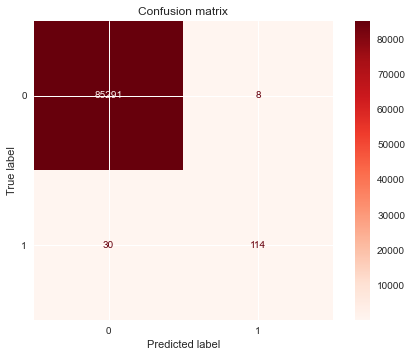

In [16]:
disp = plot_confusion_matrix(rand_f1, X_test, y_test,
                                 cmap=plt.cm.Reds)
disp.ax_.set_title("Confusion matrix")

In [17]:
print(classification_report(y_test, predictions_rf1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85299
           1       0.93      0.79      0.86       144

    accuracy                           1.00     85443
   macro avg       0.97      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443



Este primer modelo ha dado un muy buen resultado en la precisión (93%). Vamos a ir trabajando a partir de ahora en mejorar la captura de transacciones fraudulentas (recall: 79%).

Dibujamos la curva ROC.

ROC AUC=0.939


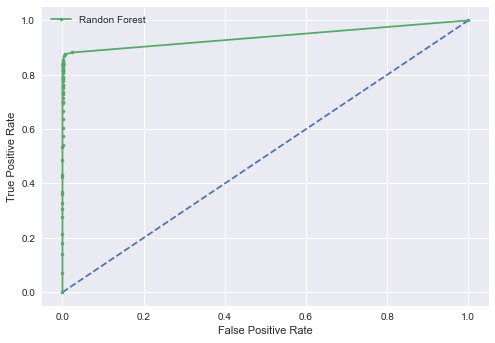

In [18]:
ns_probs = [0 for _ in range(len(y_test))]
lr_probs = rfc1.predict_proba(X_test)
lr_probs = lr_probs[:, 1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

print('ROC AUC=%.3f' % (lr_auc))

ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--', label='')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Randon Forest')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()
plt.show()

#### 2.2 Modelo con las variables más importantes

Visualizamos la importancia de las variables del modelo

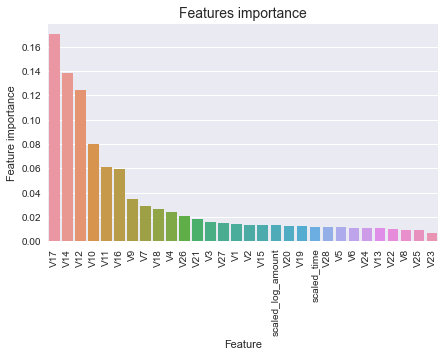

In [19]:
tmp = pd.DataFrame({'Feature': X_train.columns, 'Feature importance': rfc1.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show() 

In [20]:
tmp[tmp['Feature importance'] > 0.012].shape

(20, 2)

Entrenamos ahora el modelo con las variables más importantes.

In [21]:
predictors = tmp[tmp['Feature importance'] > 0.01].Feature.tolist()

In [22]:
rfc2 = RandomForestClassifier(n_estimators=100, random_state=101)
rand_f2 = rfc2.fit(X_train[predictors], y_train)

In [23]:
predictions_rf2 = rfc2.predict(X_test[predictors])

Text(0.5, 1.0, 'Confusion matrix important features')

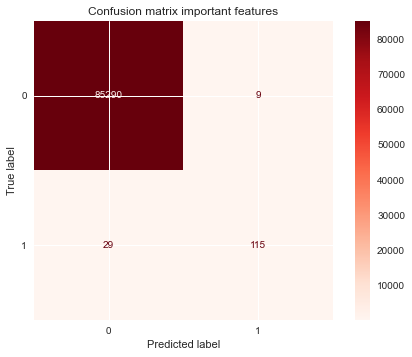

In [24]:
disp = plot_confusion_matrix(rand_f2, X_test[predictors], y_test,
                                 cmap=plt.cm.Reds)
disp.ax_.set_title("Confusion matrix important features")

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, predictions_rf2, pos_label=1)
print('AUC CV',round(auc(fpr, tpr), 2))

AUC CV 0.9


In [26]:
print(classification_report(y_test, predictions_rf2))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85299
           1       0.93      0.80      0.86       144

    accuracy                           1.00     85443
   macro avg       0.96      0.90      0.93     85443
weighted avg       1.00      1.00      1.00     85443



Al reentrenar quitando 1/3 de las variables (las 10 menos importantes), la precisión se mantiene y el recall mejora 1 punto porcentual. A partir de ahora, entrenaremos con estas variables el resto de los modelos, ya que las menos importantes podrían estar metiendo ruido al modelo.

#### 2.3 Modelo con Over Sampling

Con objetivo de aumentar nuestro recall y capturar el máximo número de operaciones fraudulentas posible, vamos a realizar oversampling, para balancear el dataset y así dar más peso en el modelo a las operaciones de fraude.

In [27]:
print("Nº registros dataset x_train: ", X_train[predictors].shape)
print("Nº registros dataset y_train: ", y_train.shape)
print("Nº registros dataset x_test: ", X_test[predictors].shape)
print("Nº registros dataset y_test: ", y_test.shape)

print("Antes de OverSampling, conteo de etiquetas '1': {}".format(sum(y_train==1)))
print("Antes de OverSampling, conteo de etiquetas '0': {} \n".format(sum(y_train==0)))

sm = SMOTE(random_state=2)
X_train_s, y_train_s = sm.fit_sample(X_train[predictors], y_train.ravel())

print('Después de OverSampling, tamaño de train_x: {}'.format(X_train_s[predictors].shape))
print('Después de OverSampling, tamaño de train_y: {} \n'.format(y_train_s.shape))

print("Después de OverSampling, conteo de etiquetas '1': {}".format(sum(y_train_s==1)))
print("Después de OverSampling, conteo de etiquetas '0': {}".format(sum(y_train_s==0)))

Nº registros dataset x_train:  (199364, 26)
Nº registros dataset y_train:  (199364,)
Nº registros dataset x_test:  (85443, 26)
Nº registros dataset y_test:  (85443,)
Antes de OverSampling, conteo de etiquetas '1': 348
Antes de OverSampling, conteo de etiquetas '0': 199016 

Después de OverSampling, tamaño de train_x: (398032, 26)
Después de OverSampling, tamaño de train_y: (398032,) 

Después de OverSampling, conteo de etiquetas '1': 199016
Después de OverSampling, conteo de etiquetas '0': 199016


In [28]:
rfc3 = RandomForestClassifier(n_estimators=100, random_state=101)
rf_s = rfc3.fit(X_train_s[predictors], y_train_s)
predictions_rf = rfc3.predict(X_test[predictors])

In [29]:
print(classification_report(y_test,predictions_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85299
           1       0.90      0.83      0.86       144

    accuracy                           1.00     85443
   macro avg       0.95      0.91      0.93     85443
weighted avg       1.00      1.00      1.00     85443



Este modelo ha subido el recall del 80% al 83% respecto al anterior, pero nos ha penalizado la precisión, bajando del 93% al 90%. Sería decisión de la empresa qué objetivo perseguir.

Text(0.5, 1.0, 'Confusion Matrix Over Sampling')

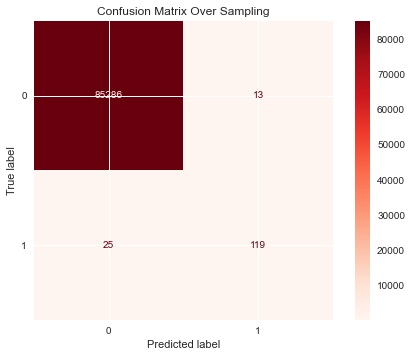

In [30]:
disp = plot_confusion_matrix(rf_s, X_test[predictors], y_test, cmap=plt.cm.Reds)
disp.ax_.set_title("Confusion Matrix Over Sampling")

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, predictions_rf, pos_label=1)
print('AUC CV',round(auc(fpr, tpr), 2))

AUC CV 0.91


Text(0.5, 1.0, 'Curva Precision - Recall')

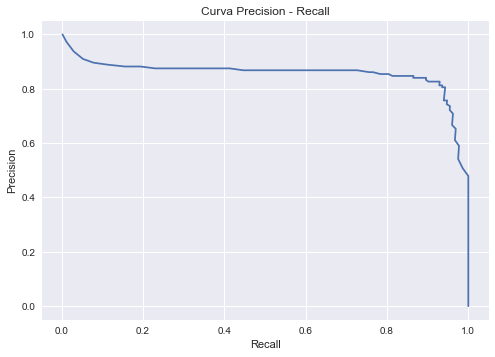

In [32]:
y_pred_prob = rf_s.predict_proba(X_test[predictors])[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
plt.plot(precision, recall)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision - Recall')

#### 2.4 Búsqueda de parámetros óptimos

Creamos una celda de parámetros para buscar los que mejor se ajustan.

In [31]:
#Se ha reducido el volumen de la celda para reducir el tiempo de computación
n_estimators = [50, 100, 200]
max_features = ['auto', 'sqrt']
max_depth = [5, 10, 20]
min_samples_split = [5, 10]
min_samples_leaf = [2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [50, 100, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 10, 20], 'min_samples_split': [5, 10], 'min_samples_leaf': [2, 4], 'bootstrap': [True, False]}


La búsqueda de parámetros óptimos vamos a hacerla sobre la muestra original.

In [41]:
rfc4 = RandomForestClassifier()

rf_random = RandomizedSearchCV(estimator = rfc4, 
                               param_distributions = random_grid, 
                               n_iter = 100, 
                               cv = 2, 
                               verbose=2, 
                               random_state=101, 
                               n_jobs = -1)
rf_random.fit(X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 34.2min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 48.7min finished


RandomizedSearchCV(cv=2, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [42]:
rf_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}

#### 2.5 Modelo con parámetros óptimos y entrenado usando Validación Cruzada

Para poder evaluar el Dataset completo, entrenamos el modelo con validación cruzada y 5 kfolds, utilizando en el modelo los mejores parámetros encontrados en el paso anterior.

In [34]:
model = RandomForestClassifier(n_estimators=100,
                               min_samples_split = 10,
                               min_samples_leaf = 2,
                               max_features = 'sqrt',
                               max_depth = 10,
                               bootstrap = False,
                               random_state = 101)

cv = model_selection.KFold(n_splits=5)
list_score = []
index_train = []
index_test = []
y_values = []

for train_index, test_index in cv.split(X):
    
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    model.score(X_test, y_test)
    y_pred = model.predict(X_test)

    list_score.append(y_pred.tolist())
    index_train.append(train_index.tolist())
    index_test.append(test_index.tolist())
    y_values.append(y_test.tolist())

TRAIN: [ 56962  56963  56964 ... 284804 284805 284806] TEST: [    0     1     2 ... 56959 56960 56961]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [ 56962  56963  56964 ... 113921 113922 113923]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [113924 113925 113926 ... 170882 170883 170884]
TRAIN: [     0      1      2 ... 284804 284805 284806] TEST: [170885 170886 170887 ... 227843 227844 227845]
TRAIN: [     0      1      2 ... 227843 227844 227845] TEST: [227846 227847 227848 ... 284804 284805 284806]


In [35]:
score = sum(list_score, [])
y_test_val = sum(y_values, [])

In [36]:
print(confusion_matrix(y_test_val, score))

[[284256     59]
 [   113    379]]


In [42]:
fpr, tpr, thresholds = metrics.roc_curve(y_test_val, score, pos_label=1)
print('AUC CV',round(metrics.auc(fpr, tpr), 2))

AUC CV 0.89


In [38]:
print(classification_report(y_test_val,score))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    284315
           1       0.87      0.77      0.82       492

    accuracy                           1.00    284807
   macro avg       0.93      0.89      0.91    284807
weighted avg       1.00      1.00      1.00    284807



### Conclusiones

Se pueden conseguir buenos resultados con el dataset balanceado y también con el dataset origen. Con el dataset balanceado se consiguen los mejores resultados de Recall y con el dataset origen se consigue la mejor precisión. Random Forest se comporta bien en este ejercicio, consiguiendo un 0.89 de AUC, un 87% de precision y un 77% de recall, evaluado sobre el dataset completo.